In [0]:
!pip install PyDrive

In [0]:
!ls

In [0]:

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1kfUcDYHPdGkOyfhsYO2xPYQ9THStwdZu'})
download.GetContentFile('102623729836648532953-raw-reply-pairs.pkl')

In [0]:
download = drive.CreateFile({'id': '1V-ogRtNQ9xr5JglcPw-zAjp-O7mjzEva'})
download.GetContentFile('108371130441830548619-raw-reply-pairs.pkl')

In [0]:
import tensorflow as tf
import numpy as np
import pickle
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:

with open('102623729836648532953-raw-reply-pairs.pkl', 'rb') as f:
    data_102 = pickle.load(f)
with open('108371130441830548619-raw-reply-pairs.pkl', 'rb') as f:
    data_108 = pickle.load(f)


In [3]:
print('Number of records in 102:', len(data_102))
print('Number of records in 108:', len(data_108))
email_data=data_102

Number of records in 102: 856
Number of records in 108: 1969


In [5]:
i=np.random.random_integers(len(email_data)-1)
print(i)
print(email_data[i][0]['message_core_body_sentences'])
print(email_data[i][1]['message_core_body_sentences'])

184
["PERSON_NAME, I'm going to be a field trip for AP Spanish starting period 3.", 'My next free period will be period 3 on Thursday.', '- Lambert On Mon, Jan 28, 2013 at 3:35 PM, PERSON_NAME <EMAIL_ADDRESS>wrote: > Hey PERSON_NAME,**** > > ** ** > > I want to chat real quickly with you tomorrow.', 'What period are you free > tomorrow?', '**** > > ** ** > > Mr. PERSON_NAME**** > > ** ** > > PERSON_NAME**** > > School Counselor **** > > LOCATION **** > > LOCATION**** > > PHONE_NUMBER**** > > PHONE_NUMBER (fax)**** > > ** ** >']
['I want to chat real quickly with you tomorrow.', 'What period are you free tomorrow?', 'Mr. PERSON_NAME, NY 11568 PHONE_NUMBER PHONE_NUMBER (fax)']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 855 + 1) instead
  """Entry point for launching an IPython kernel.


In [0]:
import requests
import json
import numpy as np


def _chunks(collection, chunk_size):
    chunk_size = max(1, chunk_size)
    return (collection[i:i + chunk_size] for i in range(0, len(collection), chunk_size))


class USEClient(object):
    def __init__(self, base_url="https://sentence-encoder.pointapi.com"):
        """ Create a new Universal Sentence Encoder Client
        :param base_url: the base URL of the server
        """
        self.endpoint = base_url + '/v1/models/USE:predict'

    def encode_text(self, text):
        """ Encode a piece of text.
        :param text: some text (str)
        :return: a np.array of shape (512,)
        """
        body = {"instances": [text]}
        r = requests.post(self.endpoint, data=json.dumps(body))
        return np.array(r.json()['predictions'][0])

    def encode_texts(self, texts, batch_size=1000):
        """ Encode a piece of text.
        Note: Requests will be sent in batches of maximum 1000 (`batch_size`)
        sentences per batch to avoid `413 Request Entity Too Large` error.
        :param texts: some texts ([str, ...])
        :param batch_size: how many sentences to put in a single request
        :return: a np.array of shape (?, 512)
        """
        results = []
        for batch in _chunks(texts, batch_size):
            body = {"instances": batch}
            r = requests.post(self.endpoint, data=json.dumps(body))
            results.append(np.array(r.json()['predictions']))

        return np.concatenate(results)

    def sentence_similarity(self, s0, s1):
        """ Compute sentence similarity
        :param s0: a sentence (str)
        :param s1: a sentence (str)
        :return: a float in range [0,1]
        """
        v0 = np.array(self.encode_text(s0))
        v1 = np.array(self.encode_text(s1))

        return np.dot(v0, v1) / (np.sqrt(v0.dot(v0)) * np.sqrt(v1.dot(v1)))
client = USEClient(base_url="https://sentence-encoder.pointapi.com")
sentences = ["Hello!", "How do you do?"]
encodings=client.encode_texts(sentences)


In [0]:
def count_letters(input_string, valid_letters=string.ascii_letters):
    count = Counter(input_string) 
    return sum(count[letter] for letter in valid_letters)
email_response=[[] for i in range(len(email_data))]
for i in range(len(email_data)):
  if (len(email_data[i][0]['message_core_body_sentences'])!=0):
    string_list=[re.sub('[#*<>?-]','',each_sent) for each_sent in email_data[i][0]['message_core_body_sentences']]
    pruned_str_list=[]    
    for each_sent in string_list:         
      each_sent=' '.join(each_sent.split())
      if ('thank' not in each_sent.lower()) and ('sincere' not in each_sent.lower()) and (count_letters(each_sent.lower())>3):
        pruned_str_list.append(each_sent)                        
    email_response[i]=pruned_str_list

In [7]:
i=np.random.random_integers(len(email_data)-1)
print(email_response[i])
print(email_data[i][0]['message_core_body_sentences'])

["It's great to meet you over email, PERSON_NAME.", "Like PERSON_NAME said, I'd like to chat with you to see if you'd be a good fit on the Point team.", 'Are you available sometime this weekend for a 30 minute Skype call', 'Looking forward to talking to you soon.', 'Best, PERSON_NAME ________________________ PERSON_NAME CTO and cofounder of Point.', 'https://pointmail.io/LOCATION Class of 2017']
['Thanks for the intro, Fil!', "It's great to meet you over email, PERSON_NAME.", "Like PERSON_NAME said, I'd like to chat with you to see if you'd be a good fit on the Point team.", 'Are you available sometime this weekend for a 30 minute Skype call?', 'Looking forward to talking to you soon.', 'Best, PERSON_NAME *__**__**__**__**__**__**__**__**__**__**__**__* *PERSON_NAME* *CTO and co-founder of Point.', '<https://pointmail.io/>LOCATION Class of 2017*']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 855 + 1) instead
  """Entry point for launching an IPython kernel.


In [0]:
email_response_embeddings=[[] for i in range(len(email_response))]
for i in range(len(email_response)):
  if (len(email_response[i])!=0):
    email_response_embeddings[i]=client.encode_texts(email_response[i])

In [0]:
response_phrase_embedding=[]
response_phrase_indexing=[]
for i in range(len(email_response_embeddings)):
  if (len(email_response_embeddings[i])!=0):
    for j in range(len(email_response_embeddings[i])):
      response_phrase_embedding.append(email_response_embeddings[i][j])
      response_phrase_indexing.append([i,j])

In [12]:
print(len(response_phrase_embedding))
print(len(response_phrase_indexing))
response_phrase_indexing[23]

5465
5465


[4, 3]

In [0]:
response_phrase_distance_matrix=np.zeros((len(response_phrase_embedding),len(response_phrase_embedding)))
for i in range(len(response_phrase_embedding)):
  for j in range(i+1,len(response_phrase_embedding)):
    response_phrase_distance_matrix[i][j]=np.linalg.norm(response_phrase_embedding[i]-response_phrase_embedding[j])

In [0]:
response_phrase_distance_vector=np.reshape(response_phrase_distance_matrix,len(response_phrase_embedding)*len(response_phrase_embedding))

In [90]:
distance_threshold=0.1
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)
distance_threshold=0.2
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)
distance_threshold=0.4
number_of_similar_phrases=np.sum(response_phrase_distance_vector<distance_threshold)-(response_phrase_distance_vector.shape[0]-len(response_phrase_embedding))/2+len(response_phrase_embedding)
print('number_of_similar_phrases for threshold ', distance_threshold,':', number_of_similar_phrases)

number_of_similar_phrases for threshold  0.1 : 16886.0
number_of_similar_phrases for threshold  0.2 : 16982.0
number_of_similar_phrases for threshold  0.4 : 17748.0


(5465, 1)


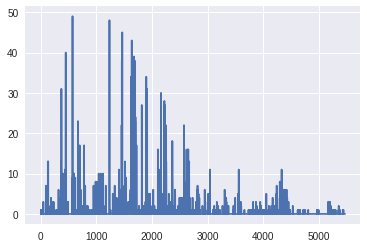

In [91]:
distance_threshold=0.4
response_phrase_distance_cluster=[]
response_phrase_distance_score=np.sum(np.logical_and((response_phrase_distance_matrix<distance_threshold),(response_phrase_distance_matrix>0)),axis=1,keepdims=True)
print(response_phrase_distance_score.shape)
plt.plot(response_phrase_distance_score) 
plt.show()

In [92]:
thres_freq=10
top_response_phrases_distance_index=np.where(response_phrase_distance_score>thres_freq)[0]
#print(top_response_phrases_index)
for i in range(len(top_response_phrases_distance_index)):
  k,l=response_phrase_indexing[top_response_phrases_distance_index[i]]
  print(email_response[k][l])


Resume_Draft.pdf
Resume_Draft.pdf
PERSON_NAME School Counselor LOCATION LOCATION PHONE_NUMBER PHONE_NUMBER (fax)
PERSON_NAME School Counselor LOCATION LOCATION PHONE_NUMBER PHONE_NUMBER (fax)
________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
Dr. PERSON_NAME
Upload jokes, photos and more.
It's free!
http://g.msn.com/8HMBENUS/2755PS=47575
________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
https://pointmail.io/LOCATION Class of 2017
PERSON_NAME
PERSON_NAME.
________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
Mr. PERSON_NAME PERSON_NAME School Counselor LOCATION LOCATION PHONE_NUMBER PHONE_NUMBER (fax)
https://pointmail.io/LOCATION Class of 2017
Best, PERSON_NAME ________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
https://pointmail.io/LOCATION Class of 2017
_____

In [0]:
response_phrase_dotproduct_matrix=np.zeros((len(response_phrase_embedding),len(response_phrase_embedding)))
for i in range(len(response_phrase_embedding)):
  for j in range(i+1,len(response_phrase_embedding)):
    response_phrase_dotproduct_matrix[i][j]=np.dot(response_phrase_embedding[i],response_phrase_embedding[j])
    
response_phrase_dotproduct_vector=np.reshape(response_phrase_dotproduct_matrix,len(response_phrase_embedding)*len(response_phrase_embedding))    

In [14]:
dot_threshold=0.7
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)
dot_threshold=0.8
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)
dot_threshold=0.9
number_of_similar_phrases=np.sum(response_phrase_dotproduct_vector>dot_threshold)
print('number_of_similar_phrases for threshold ', dot_threshold,':', number_of_similar_phrases)

number_of_similar_phrases for threshold  0.7 : 24635
number_of_similar_phrases for threshold  0.8 : 10710
number_of_similar_phrases for threshold  0.9 : 7493


(5465, 1)


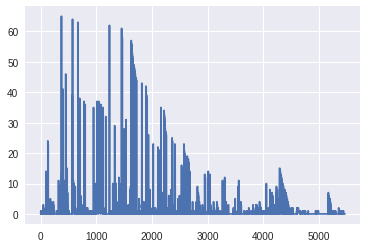

In [15]:
dot_threshold=0.9
response_phrase_cluster=[]
response_phrase_dotproduct_score=np.sum((response_phrase_dotproduct_matrix>dot_threshold),axis=1,keepdims=True)
print(response_phrase_dotproduct_score.shape)
plt.plot(response_phrase_dotproduct_score) 
plt.show()

In [16]:
thres_freq=10
top_response_phrases_dotprod_index=np.where(response_phrase_dotproduct_score>thres_freq)[0]
#print(top_response_phrases_index)
for i in range(len(top_response_phrases_dotprod_index)):
  k,l=response_phrase_indexing[top_response_phrases_dotprod_index[i]]
  print(email_response[k][l])

Dr. PERSON_NAME
Dr. PERSON_NAME
Dr. PERSON_NAME
Resume_Draft.pdf
Resume_Draft.pdf
No problem.
PERSON_NAME School Counselor LOCATION LOCATION PHONE_NUMBER PHONE_NUMBER (fax)
PERSON_NAME School Counselor LOCATION LOCATION PHONE_NUMBER PHONE_NUMBER (fax)
________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
PERSON_NAME
Dr. PERSON_NAME
Upload jokes, photos and more.
It's free!
http://g.msn.com/8HMBENUS/2755PS=47575
Abdale
PERSON_NAME
________________________ PERSON_NAME CTO and cofounder of Point.
https://pointmail.io/LOCATION Class of 2017
PERSON_NAME ________________________________ With MSN Spaces email straight to your blog.
Upload jokes, photos and more.
It's free!
https://pointmail.io/LOCATION Class of 2017
PERSON_NAME
PERSON_NAME.
PERSON_NAME
PERSON_NAME
http://g.msn.com/8HMAENUS/2731PS=47575
http://g.msn.com/8HMAENUS/2749PS=47575
http://g.msn.com/8HMAENUS/2749PS=47575
http://g.msn.com/8HMAENUS/2749PS=47575
http://g.msn.com/8HMA

In [95]:
print('Number of top response phrases through distance metric:',len(top_response_phrases_distance_index))
print('Number of top response phrases through dot product metric:',len(top_response_phrases_dotprod_index))

Number of top response phrases through distance metric: 91
Number of top response phrases through dot product metric: 184


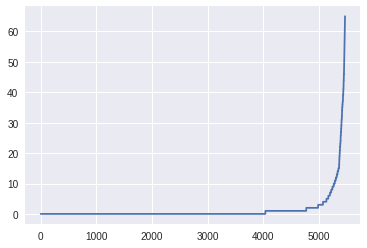

[ 373  572  669 ... 2127 2133 5464]


In [17]:
response_phrase_dotproduct_sorted_idx = np.argsort(-response_phrase_dotproduct_score.flatten())
plt.plot(np.sort(response_phrase_dotproduct_score.flatten())) 
plt.show()
print(response_phrase_dotproduct_sorted_idx)

In [0]:
#This is a very naive way of clustering the sentence embeddings
unique_response_phrases_dotproduct=[]
unique_response_phrases_dotproduct_index=[[]]
unique_response_phrases_dotproduct.append(response_phrase_embedding[response_phrase_dotproduct_sorted_idx[0]])
unique_response_phrases_dotproduct_index[0].append(response_phrase_dotproduct_sorted_idx[0])

for i in range(1,len(response_phrase_embedding)):
  print(i)
  for j in range(len(unique_response_phrases_dotproduct)):    
    if (np.dot(response_phrase_embedding[response_phrase_dotproduct_sorted_idx[i]],unique_response_phrases_dotproduct[j])>dot_threshold):
      unique_response_phrases_dotproduct[j]=(unique_response_phrases_dotproduct[j]+response_phrase_embedding[response_phrase_dotproduct_sorted_idx[i]])/2
      unique_response_phrases_dotproduct_index[j].append(response_phrase_dotproduct_sorted_idx[i])
    else:
      unique_response_phrases_dotproduct.append(response_phrase_embedding[response_phrase_dotproduct_sorted_idx[i]])
      unique_response_phrases_dotproduct_index.append([response_phrase_dotproduct_sorted_idx[i]])

    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [123]:
print(unique_response_phrases_dotproduct_index[0])

[373, 572, 669, 1235, 1453, 1458, 1461, 1465, 1626, 1631, 1635, 1638, 1644, 1647, 1650, 1654, 1676, 1683, 1688, 1698, 1703, 1720, 1816, 1891, 1894, 1896, 1900, 1904, 1907, 1911]


In [113]:
a=[[]]
a[0].append(1)
a[0].append(2)
a
a.append([1])
a

[[1, 2], [1]]